# Benchmarking of Custom Numerical Integration Functions
*September 19th 2021*

**Aim - Benchmark different numerical integration functions are choose the best implementation to use in autoRS.core.utils**

Ideally, we can just import scipy.integrate.cumulative_trapezoidal. However, scipy is a very large library that would make the .exe file made with pyinstaller unnecessarily big. So, we can implement a custom integration functions in autoRS.core.utils.
- Implement cumulative Simpson's rule integration function. 
- Compare results to numpy.cumulative_trapezoidal
- Compare against theoretical solutions.

In [62]:
# Standard library imports
import os
import sys
from itertools import product, accumulate
from time import perf_counter
from typing import Optional

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import cumtrapz, simps

# Add project root to path
pkg_path = os.path.abspath("..")
if pkg_path not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))

# Local application imports
import autoRS

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Implement Simpson's rule cumulative integration function

In [459]:
def cumulative_trapezoidal(
    y: np.ndarray, x: Optional[np.ndarray] = None, dx: float = 1, 
    initial: Optional[float] = 0,
) -> np.ndarray:
    """Trapezoidal integration of samples."""
    y = np.asarray(y)
    if x is not None:
        x = np.asarray(x)
    else:
        x = np.arange(0, dx*len(y), dx)
    
    sub_integrals = np.diff(x) * (y[:-1] + y[1:])/2
    
    return np.cumsum(np.concatenate(([initial], sub_integrals)))
    
    
def cumulative_integral_3(
    y: np.ndarray, x: Optional[np.ndarray] = None, dx: float = 1, 
    initial: Optional[float] = 0,
) -> np.ndarray:
    """1/3 composite simpson's rule"""
    y = np.asarray(y)
    if x is not None:
        x = np.asarray(x)
    else:
        x = np.arange(0, dx*len(y), dx)
    res = [initial]
    
    # Trapezoidal rule for the first integration point
    value = (x[1] - x[0]) * (y[1] + y[0])/2
    res.append(res[-1] + value)
    
    if len(y) == 2:
        return np.asarray(res)
    
    # 1/3 Simpson's rule for all remaining value
    sub_integrals = (x[2:] - x[:-2])/6 * (y[:-2] + 4*y[1:-1] + y[2:])
    for value in sub_integrals:
        res.append(res[-2] + value)
        
    return np.asarray(res)


def cumulative_integral_8(
    y: np.ndarray, x: Optional[np.ndarray] = None, dx: float = 1, 
    initial: Optional[float] = 0,
) -> np.ndarray:
    """3/8 composite simpson's rule"""
    y = np.asarray(y)
    if x is not None:
        x = np.asarray(x)
    else:
        x = np.arange(0, dx*len(y), dx)
    res = [initial]
    
    # Trapezoidal rule for the first integration point
    value = (x[1] - x[0]) * (y[1] + y[0])/2
    res.append(res[-1] + value)
    
    if len(y) == 2:
        return np.asarray(res)
    
    # 1/3 Simpson's rule for the second integration point
    value = (x[2] - x[0])/6 * (y[2] + 4*y[1] + y[0])
    res.append(res[-2] + value)
    
    if len(y) == 3:
        return np.asarray(res)
    
    # 3/8 Simpson's rule for all remaining points
    sub_integrals = (x[3:] - x[:-3])/8 * (y[:-3] + 3*y[1:-2] + 3*y[2:-1] + y[3:])
    for value in sub_integrals:
        res.append(res[-3] + value)
        
    return np.asarray(res)

## Test Integration with Example Function

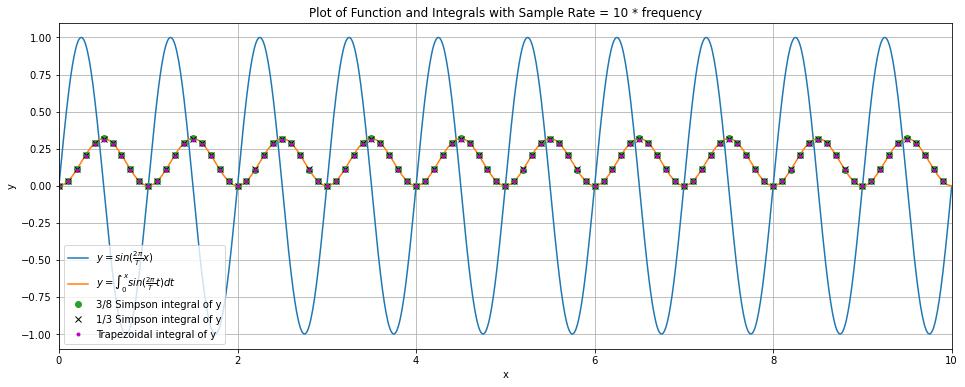

In [460]:
freq_y = 1
multiplier = 10
sample_freq_y = freq_y*multiplier
period_y = 1/freq_y
alpha = (2*np.pi/period_y)

t_max = 10
t = np.linspace(0, t_max, num=1000)
int_t = np.arange(0, t_max, 1/sample_freq_y)

def y(x):
    return np.sin(alpha*x)

def int_y(x):
    return (-np.cos(alpha*x) + 1)/alpha

simps_3_int_y = cumulative_integral_3(y(int_t), int_t, initial=0)
simps_8_int_y = cumulative_integral_8(y(int_t), int_t, initial=0)
trapz_int_y = cumtrapz(y(int_t), int_t, initial=0)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(t, y(t), label=r"$y=sin(\frac{2\pi}{T} x)$")
ax.plot(t, int_y(t), label=r"$y=\int_0^x{sin(\frac{2\pi}{T} t) dt}$")
ax.plot(int_t, simps_8_int_y, 'o', label="3/8 Simpson integral of y")
ax.plot(int_t, simps_3_int_y, 'kx', label="1/3 Simpson integral of y")
ax.plot(int_t, trapz_int_y, 'm.', label="Trapezoidal integral of y")
ax.set(xlabel="x", ylabel="y", xlim=(0, t_max), 
       title=f"Plot of Function and Integrals with Sample Rate = {multiplier} * frequency")
ax.legend(loc="lower left")
ax.grid()

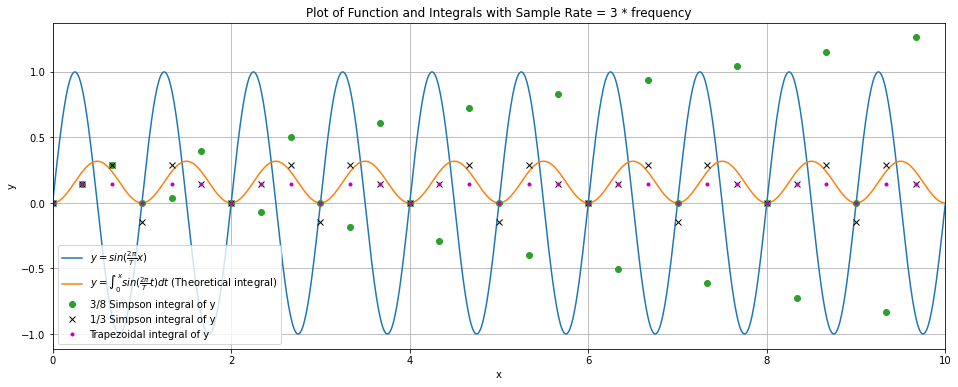

In [461]:
multiplier = 3
sample_freq_y = freq_y*multiplier
int_t = np.arange(0, t_max, 1/sample_freq_y)

simps_3_int_y = cumulative_integral_3(y(int_t), int_t, initial=0)
simps_8_int_y = cumulative_integral_8(y(int_t), int_t, initial=0)
trapz_int_y = cumtrapz(y(int_t), int_t, initial=0)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(t, y(t), label=r"$y=sin(\frac{2\pi}{T} x)$")
ax.plot(t, int_y(t), label=r"$y=\int_0^x{sin(\frac{2\pi}{T} t) dt}$ (Theoretical integral)")
ax.plot(int_t, simps_8_int_y, 'o', label="3/8 Simpson integral of y")
ax.plot(int_t, simps_3_int_y, 'kx', label="1/3 Simpson integral of y")
ax.plot(int_t, trapz_int_y, 'm.', label="Trapezoidal integral of y")
ax.set(xlabel="x", ylabel="y", xlim=(0, t_max), 
       title=f"Plot of Function and Integrals with Sample Rate = {multiplier} * frequency")
ax.legend(loc="lower left")
ax.grid()

## Validate Implementations by Comparing with Scipy.integrate Functions

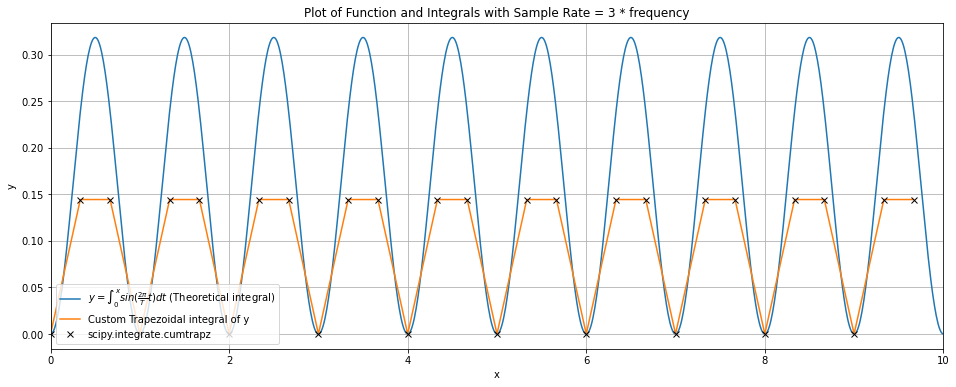

In [462]:
fig, ax = plt.subplots(figsize=(16, 6))
trapz_int_y = cumtrapz(y(int_t), int_t, initial=0)
custom_trapz_y = cumulative_trapezoidal(y(int_t), int_t, initial=0)

ax.plot(t, int_y(t), label=r"$y=\int_0^x{sin(\frac{2\pi}{T} t) dt}$ (Theoretical integral)")
ax.plot(int_t, custom_trapz_y, label="Custom Trapezoidal integral of y")
ax.plot(int_t, trapz_int_y, 'kx', label="scipy.integrate.cumtrapz")

ax.set(xlabel="x", ylabel="y", xlim=(0, t_max), 
       title=f"Plot of Function and Integrals with Sample Rate = {multiplier} * frequency")
ax.legend(loc="lower left")
ax.grid()

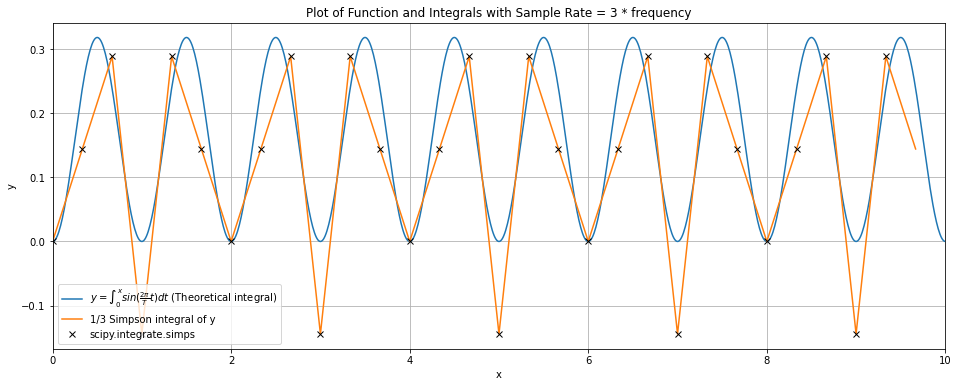

In [463]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(t, int_y(t), label=r"$y=\int_0^x{sin(\frac{2\pi}{T} t) dt}$ (Theoretical integral)")
ax.plot(int_t, simps_3_int_y, label="1/3 Simpson integral of y")
act_simps = [simps(y(int_t[:i]), int_t[:i], even='last') for i in range(1, len(int_t))]
ax.plot(int_t[:-1], act_simps, 'kx', label="scipy.integrate.simps")

ax.set(xlabel="x", ylabel="y", xlim=(0, t_max), 
       title=f"Plot of Function and Integrals with Sample Rate = {multiplier} * frequency")
ax.legend(loc="lower left")
ax.grid()

The black points match the orange line --> this validates the custom 1/3 rule simpson's implementation

## Quantify Errors

- Calculate the average error in the numerical integration over multiple sample rates.
- The example function has a period of 1s. Hence the sample rates can be though of as sample rate multipliers relative to the highest frequency of interest in a typical vibratory signal.
- Plot the average error for different numerical integration methods over the range of sample rates.
- Repeat test using an example function with multiple frequencies of motion.

In [464]:
sample_rate = np.linspace(2, 10, num=500)
int_range = max(int_y(t)) - min(int_y(t))

def get_mean_error(cum_int_func, sr, func=y, int_func=int_y):
    int_t = np.arange(0, t_max, 1/sr)
    res = cum_int_func(func(int_t), int_t, initial=0)
    error = np.mean(np.abs(int_func(int_t) - res))
    return error

simps_3_error = [get_mean_error(cumulative_integral_3, sr)/int_range for sr in sample_rate]
simps_8_error = [get_mean_error(cumulative_integral_8, sr)/int_range for sr in sample_rate]
trapz_error = [get_mean_error(cumulative_trapezoidal, sr)/int_range for sr in sample_rate]

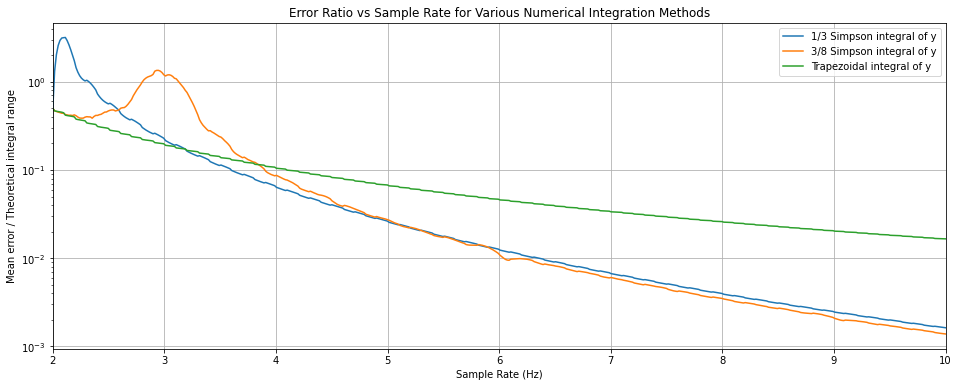

In [465]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.semilogy(sample_rate, simps_3_error, label="1/3 Simpson integral of y")
ax.semilogy(sample_rate, simps_8_error, label="3/8 Simpson integral of y")
ax.semilogy(sample_rate, trapz_error, label="Trapezoidal integral of y")
ax.grid()
ax.set(xlim=(min(sample_rate), max(sample_rate)), xlabel="Sample Rate (Hz)", 
       ylabel="Mean error / Theoretical integral range", 
       title="Error Ratio vs Sample Rate for Various Numerical Integration Methods")
ax.legend()

In [466]:
def y2(x):
    return np.sin(alpha*x) + 5*np.sin(alpha/5*x)

def int_y2(x):
    return (-np.cos(alpha*x) + 1)/alpha + 5*(-np.cos(alpha/5*x) + 1)/(alpha/5)

sample_rate = np.linspace(2, 10, num=500)
int_range = max(int_y2(t)) - min(int_y2(t))

simps_3_error2 = [get_mean_error(cumulative_integral_3, sr, y2, int_y2)/int_range for sr in sample_rate]
simps_8_error2 = [get_mean_error(cumulative_integral_8, sr, y2, int_y2)/int_range for sr in sample_rate]
trapz_error2 = [get_mean_error(cumulative_trapezoidal, sr, y2, int_y2)/int_range for sr in sample_rate]

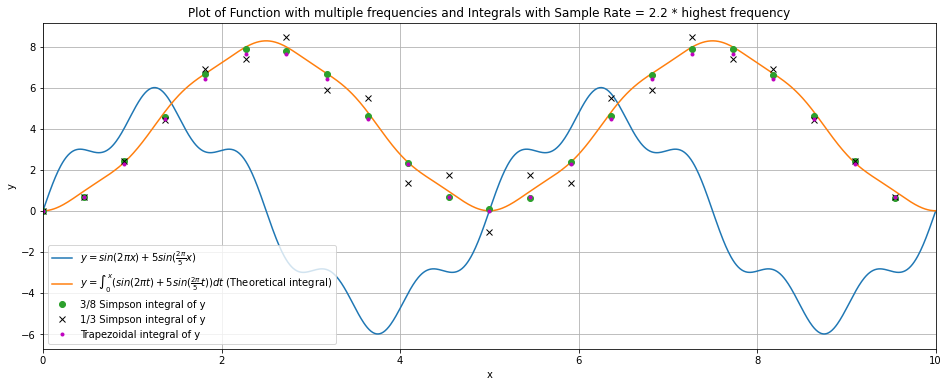

In [467]:
multiplier = 2.2
sample_freq_y = freq_y*multiplier
int_t = np.arange(0, t_max, 1/sample_freq_y)

simps_3_int_y2 = cumulative_integral_3(y2(int_t), int_t, initial=0)
simps_8_int_y2 = cumulative_integral_8(y2(int_t), int_t, initial=0)
trapz_int_y2 = cumtrapz(y2(int_t), int_t, initial=0)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(t, y2(t), label=r"$y=sin(2\pi x) + 5sin(\frac{2\pi}{5} x)$")
ax.plot(t, int_y2(t), label=r"$y=\int_0^x{(sin(2\pi t) + 5sin(\frac{2\pi}{5} t)) dt}$ (Theoretical integral)")
ax.plot(int_t, simps_8_int_y2, 'o', label="3/8 Simpson integral of y")
ax.plot(int_t, simps_3_int_y2, 'kx', label="1/3 Simpson integral of y")
ax.plot(int_t, trapz_int_y2, 'm.', label="Trapezoidal integral of y")
ax.set(xlabel="x", ylabel="y", xlim=(0, t_max), 
       title=f"Plot of Function with multiple frequencies and Integrals with Sample Rate = {multiplier} * highest frequency")
ax.legend(loc="lower left")
ax.grid()

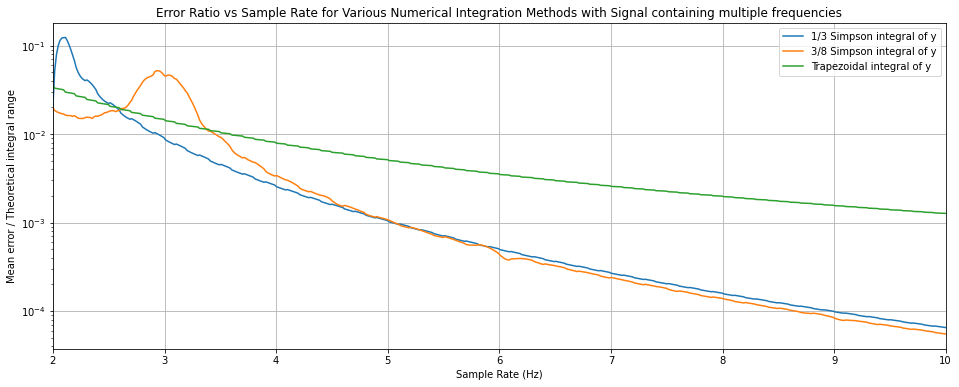

In [468]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.semilogy(sample_rate, simps_3_error2, label="1/3 Simpson integral of y")
ax.semilogy(sample_rate, simps_8_error2, label="3/8 Simpson integral of y")
ax.semilogy(sample_rate, trapz_error2, label="Trapezoidal integral of y")
ax.grid()
ax.set(xlim=(min(sample_rate), max(sample_rate)), xlabel="Sample Rate (Hz)", 
       ylabel="Mean error / Theoretical integral range", 
       title="Error Ratio vs Sample Rate for Various Numerical Integration Methods with Signal containing multiple frequencies")
ax.legend()

### Accuracy Conclusions

Observations from the case of a signal with a single frequency:
- When the sample rate is much higher than the highest frequency content in the signal (> 4x), the simpson's rules give lower error than the trapezoidal method. The accuracy quickly becomes by more than an order of magnitude.
- At low sample rates (< 4x the highest frequency content), the simpson's rule integrations are completely erroneous. The trapezoidal integration errors are also high (>10% error at rates <4x the highest frequency content).

Observations from the case of a signal with multiple frequency, where the lower frequency signal has 5x the amplitude of the higher frequency:
- A similar pattern to the case of a single frequency signal is observed: The error is initially higher for the simpson's rules, but after a certain sample rate, the error becomes orders of magnitudes smaller than the trapezoidal method.
- The sample rate at which simpson's rules become more accurate are now much smaller (~2.7x for the 1/3 rule). 

In practical terms for seismic analyses, it may be possible for the sample rate to be close to the highest frequency of interest. However, in all cases the lower frequency contentis much more dominant. Hence the scenario is more similar to the second case presented. In the vast majority of expected use cases, sample rates will likely be > 5x the highest frequency content. Hence the 1/3 simpson's rule can be used as the default option in autoRS. However, the trapezoidal option should still be provided. The 3/8 simpson's rule does not provide a higher order of accuracy than the 1/3 rule. The higher level of inaccuracy at a sample rate of 3x the highest frequency content is also less desirable than 2.2x. 

## Quantify Timing

In [475]:
def time_func(func, max_time=2, num_runs=5, func_name=None):
    cts_per_run = []
    for run in range(num_runs):
        t_ct = t0 = perf_counter()
        ct = 0
        while t_ct - t0 < max_time/num_runs:
            func()
            ct += 1
            t_ct = perf_counter()
        cts_per_run.append(ct)
    best_ct = max(cts_per_run)
    loop_time = (max_time/num_runs)/best_ct
    if func_name is not None:
        print(func_name + ":")
    print(f"{best_ct} loops in {max_time/num_runs:.3f}s, best of {num_runs}: {loop_time:.3e}s per loop")
    return loop_time

In [476]:
methods = {
    "trapezoidal": cumulative_trapezoidal,
    "1/3 simpson's rule": cumulative_integral_3,
    "3/8 simpson's rule": cumulative_integral_8,
    "scipy.integrate.cumtrapz": cumtrapz,
}

timing = [time_func(lambda: func(y(int_t), int_t, initial=0), func_name=key) for key, func in methods.items()]

trapezoidal:
19330 loops in 0.400s, best of 5: 2.069e-05s per loop
1/3 simpson's rule:
17242 loops in 0.400s, best of 5: 2.320e-05s per loop
3/8 simpson's rule:
15107 loops in 0.400s, best of 5: 2.648e-05s per loop
scipy.integrate.cumtrapz:
13498 loops in 0.400s, best of 5: 2.963e-05s per loop


[Text(0.5, 0, 'Numerical Integration method'),
 Text(0, 0.5, 'Time per loop (s)'),
 Text(0.5, 1.0, 'Timing Comparison')]

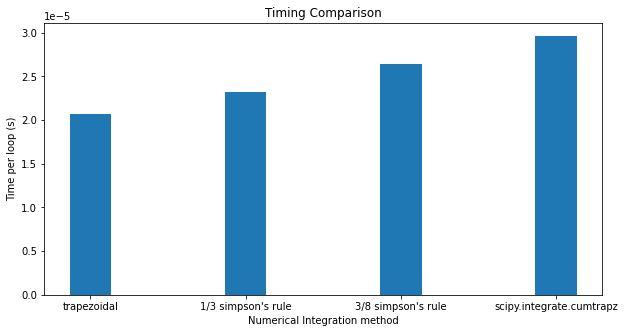

In [477]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(timing))
plt.bar(x*3, timing)
ax = plt.gca()
ax.set_xticks(x*3)
ax.set_xticklabels(methods.keys())
ax.set(
    xlabel="Numerical Integration method",
    ylabel="Time per loop (s)",
    title="Timing Comparison",
)

Custom trapezoidal integration function is the most performant. All implementations are theoretically O(n) time and space.